# 🔧 Install & Import Dependencies


In [7]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # punkt_tab is optional

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

We will explore the generation of dense word representations from text corpora, analyze the quality of these representations. The goal is to understand how to represent word meaning in a high-dimensional space and how to transfer knowledge across languages.

Please use the links below to download text corpora. \
English: https://wortschatz.uni-leipzig.de/en/download/English \
Hindi: https://wortschatz.uni-leipzig.de/en/download/Hindi

# Load the English Corpus

In [8]:
# Load corpus
with open("D:\RESEARCH related\PreCog tasks\Language_representations\Data\eng_news_2020_300K\eng_news_2020_300K\eng_news_2020_300K-sentences.txt", "r", encoding='utf8') as f:
    sentences = f.readlines()
    sentences = [sentence.strip() for sentence in sentences]

print(f"Total sentences loaded: {len(sentences)}")

<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34352\3237838278.py:2: SyntaxWarning: invalid escape sequence '\R'
  with open("D:\RESEARCH related\PreCog tasks\Language_representations\Data\eng_news_2020_300K\eng_news_2020_300K\eng_news_2020_300K-sentences.txt", "r", encoding='utf8') as f:


Total sentences loaded: 300000


# preprocessing of data
1. Lowercase
2. Remove non-alphabetic characters (removing punctuations)
3. how about stop words removal --> they impact hugely in co occurence matrices so don't do it.
4. lemitization & stemming  (does this helpful for this task)
5. Tokenize words after all 

In [9]:
# Clean and tokenize
def preprocess(sentence):
    sentence = sentence.lower()  # Lowercase
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)  # Remove punctuations and numbers
    tokens = word_tokenize(sentence)  # Tokenize using NLTK
    return tokens

# Apply to all sentences
processed_sentences = [preprocess(s) for s in sentences]

# Show a few examples
for i in range(3):
    print(processed_sentences[i])

['will', 'go', 'toward', 'building', 'resilience', 'for', 'maines', 'businesses']
['millionverifier', 'an', 'email', 'services', 'company', 'that', 'provides', 'email', 'verification', 'and', 'deliverability', 'support']
['more', 'or', 'less']


### For this task, should we employ stemming or lemmatization❓ 
No. \
Lemmatization and stemming eliminate subtle meaning differences by reducing word forms to their base or root, which is why we avoid them. To better represent how words are used in various contexts, we aim to maintain all natural word forms in word embeddings.

### Build Vocabulary : after experimenting, build vocab_sizes with 10k words

In [10]:
# Flatten tokens to build vocab
flat_words = [word for sentence in processed_sentences for word in sentence]
vocab_counter = Counter(flat_words)

# Keep top N words
vocab_size = 10000  # You can experiment here with different different vocab_size like 10k, 20k etc
vocab = [word for word, freq in vocab_counter.most_common(vocab_size)]

Now that we've built the vocabulary from the most frequent words, how can we assign meaningful IDs to these words instead of just arbitrary numbers?

There are several strategies we can use:

Frequency-based indexing ---> (most common and efficient)

POS-based ordering ---> (useful for linguistic analysis)


# Frequency-based --> Most common & efficient

In [11]:
# Frequency-based --> Most common & efficient

# Create word2id and id2word mappings
word2id = {word: i for i, word in enumerate(vocab)}
id2word = {i: word for i, word in enumerate(vocab)}

### Building the Co-occurrence Matrix
We construct the co-occurrence matrix by counting how often word pairs appear within a context window, which can be adjusted based on experimentation. For each sentence, we update the matrix for every target-context word pair found within the specified window size.

### Choosing Window Size

Small (2-5 words): Captures local relationships (syntax). \
Medium (5-10 words): Captures semantic meaning.\
Large (>10 words): Captures broader context.

In [12]:
### Construct the Co-occurrence Matrix
import numpy as np
from tqdm import tqdm
cooc_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
window_size = 4  # To capture semantic meaning, keep the window size between 2 and 5.

for sentence in tqdm(processed_sentences):
    sentence = [word for word in sentence if word in word2id]
    for idx, word in enumerate(sentence):
        word_id = word2id[word]
        start = max(0, idx - window_size)
        end = min(len(sentence), idx + window_size + 1)
        for i in range(start, end):
            if i != idx:
                context_id = word2id[sentence[i]]
                cooc_matrix[word_id][context_id] += 1

  0%|          | 0/300000 [00:00<?, ?it/s]

100%|██████████| 300000/300000 [03:44<00:00, 1337.02it/s]


# What's next?

To turn that matrix into word embeddings, you need to apply a technique like: \

Method -----> What it does \
PCA / SVD -----> Reduce matrix to low-dimensional dense vectors \
NMF (Non-negative Matrix Factorization) ---> Factorizes co-occurrence matrix into interpretable non-negatives \
GloVe -----> Uses the co-occurrence matrix to train word vectors \
word2vec -----> Learns embeddings directly via neural nets (skip-gram/CBOW)

In [13]:
from sklearn.decomposition import TruncatedSVD

# Function to perform SVD and reduce the co-occurrence matrix
def reduce_dimensions(cooc_matrix, d):
    svd = TruncatedSVD(n_components=d, random_state=42)
    reduced_matrix = svd.fit_transform(cooc_matrix)
    return reduced_matrix

# Experimenting with different values of d
d_values = [50, 100, 200, 300]  # You can experiment with other values like 10, 500, etc.

# Store the reduced matrices for different d values
reduced_matrices = {}

for d in d_values:
    print(f"Reducing dimensions to {d}...")
    reduced_matrix = reduce_dimensions(cooc_matrix, d)
    reduced_matrices[d] = reduced_matrix

# Reduced matrices now contain the embeddings for each word in reduced space

Reducing dimensions to 50...
Reducing dimensions to 100...
Reducing dimensions to 200...
Reducing dimensions to 300...


Visualizing embeddings with d=50...
Visualizing embeddings with d=100...
Visualizing embeddings with d=200...
Visualizing embeddings with d=300...


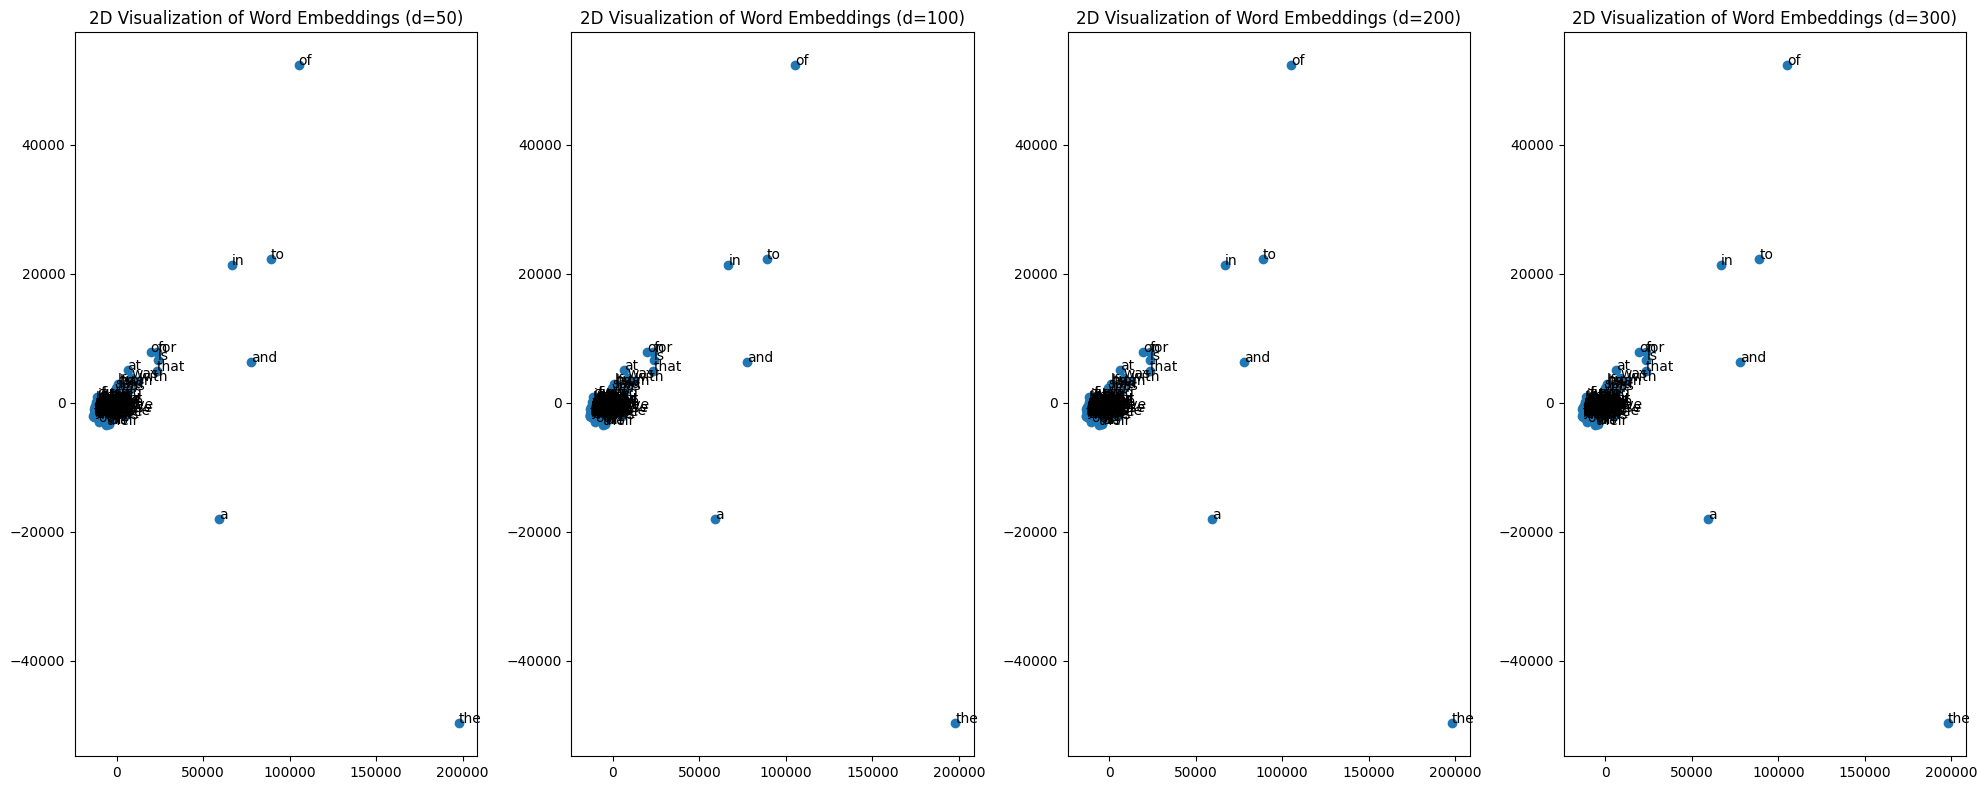

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Visualizing reduced embeddings using PCA
def visualize_embeddings(reduced_matrix, vocab, num_words=100, ax=None):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(reduced_matrix[:num_words])  # Take first 'num_words' for visualization
    
    # Plotting on the provided axis (ax) to use subplots
    ax.scatter(pca_result[:, 0], pca_result[:, 1])
    
    for i in range(num_words):
        ax.annotate(vocab[i], (pca_result[i, 0], pca_result[i, 1]))
    
    ax.set_title(f"2D Visualization of Word Embeddings (d={reduced_matrix.shape[1]})")

# Create subplots for different d values
fig, axes = plt.subplots(1, len(d_values), figsize=(20, 8))

# If there’s only one subplot, make axes a list
if len(d_values) == 1:
    axes = [axes]

# Visualize the reduced matrices for different values of d
for i, d in enumerate(d_values):
    print(f"Visualizing embeddings with d={d}...")
    visualize_embeddings(reduced_matrices[d], vocab, ax=axes[i])

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

# Check for cosine similarity between words

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two words
def get_similarity(word1, word2, reduced_matrix, word2id):
    if word1 in word2id and word2 in word2id and word2id[word1] < len(reduced_matrix) and word2id[word2] < len(reduced_matrix):
        vec1 = reduced_matrix[word2id[word1]]
        vec2 = reduced_matrix[word2id[word2]]
        return cosine_similarity([vec1], [vec2])[0][0]
    else:
        return "One or both words not in vocabulary."

# Example similarity checks after dimensionality reduction
print(get_similarity("king", "queen", reduced_matrices[100], word2id))  # High similarity
print(get_similarity("king", "sword", reduced_matrices[100], word2id))    # Low similarity
print(get_similarity("king", "virat", reduced_matrices[100], word2id))    # No similarity -> OOV

0.98660016
0.7887545
One or both words not in vocabulary.


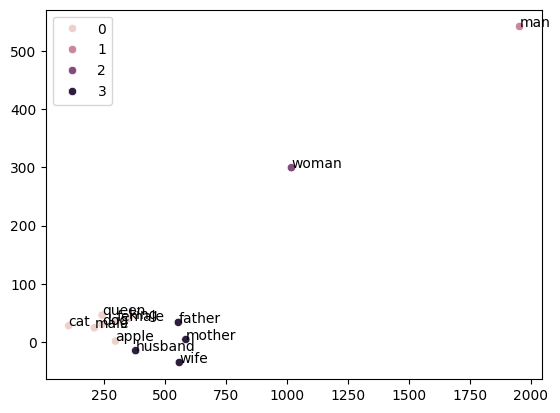

In [16]:
### clustering

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster and plot a few common words
words = ["king", "queen", "man", "woman", "apple", "dog", "cat", "father", "mother", "male", "female", "husband", "wife"]
vecs = [reduced_matrix[word2id[w]] for w in words]
labels = KMeans(n_clusters=4).fit_predict(vecs)

sns.scatterplot(x=[v[0] for v in vecs], y=[v[1] for v in vecs], hue=labels)
for i, word in enumerate(words):
    if word in word2id:  # Only annotate words present in word2id
        plt.text(vecs[i][0], vecs[i][1], word)
plt.show()

# how about checking for Contextualized Evaluation 

In [27]:
def build_contextual_cooc_matrix(context_lines, target_words, shared_vocab=None, window_size=2):
    word2id = {} if shared_vocab is None else {word: idx for idx, word in enumerate(shared_vocab)}
    data = []

    for line in context_lines:
        tokens = line.lower().split()
        for idx, word in enumerate(tokens):
            if word in target_words:
                context_ids = []
                for i in range(idx - window_size, idx + window_size + 1):
                    if 0 <= i < len(tokens) and i != idx:
                        context_word = tokens[i]
                        if context_word not in word2id:
                            word2id[context_word] = len(word2id)
                        context_ids.append(word2id[context_word])
                data.append((word2id[word], context_ids))

    vocab = [None] * len(word2id)
    for w, i in word2id.items():
        vocab[i] = w

    # Create matrix
    matrix = np.zeros((len(word2id), len(word2id)))
    for center, contexts in data:
        for context in contexts:
            matrix[center, context] += 1

    return matrix, word2id, vocab

In [29]:
# Create shared vocabulary from both corpora
all_tokens = set()
for line in finance_corpus + river_corpus:
    all_tokens.update(line.lower().split())
shared_vocab = sorted(list(all_tokens))  # sort to keep it consistent

# Build aligned co-occurrence matrices
matrix_fin, word2id_fin, vocab_fin = build_contextual_cooc_matrix(finance_corpus, ['bank'], shared_vocab)
matrix_riv, word2id_riv, vocab_riv = build_contextual_cooc_matrix(river_corpus, ['bank'], shared_vocab)

# Extract vectors
vec_bank_fin = matrix_fin[word2id_fin['bank']]
vec_bank_riv = matrix_riv[word2id_riv['bank']]

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_shift = cosine_similarity([vec_bank_fin], [vec_bank_riv])[0][0]
print(f"Contextual similarity shift for 'bank': {similarity_shift:.4f}")


Contextual similarity shift for 'bank': 0.5040


# Evaluate the Quality of the Embeddings

In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Select a few words to test similarity (e.g., 'king', 'queen', 'man', 'woman')
words_to_check = ['king', 'queen', 'man', 'woman']
word_indices = [word2id[word] for word in words_to_check]

# Use 'embeddings' instead of 'reduced_matrix'
word_vectors = reduced_matrix[word_indices]

# Calculate cosine similarity between word vectors
cos_sim = cosine_similarity(word_vectors)
print("Cosine Similarity Matrix:\n", cos_sim)
print("\nWord Vectors:")
# Extract the vectors for 'king', 'queen', 'man', 'woman'
king, queen, man, woman = word_vectors

# Compute king - queen + woman and see if it is closest to the man vector
analogy_vector = king - queen + woman

# Calculate the cosine similarity between the analogy result and all word vectors
analogy_similarities = cosine_similarity([analogy_vector], reduced_matrix)

# Find the word most similar to the analogy vector
most_similar_word_idx = np.argmax(analogy_similarities)
most_similar_word = id2word[most_similar_word_idx]

print(f"Most similar word to 'king - queen + woman' is: {most_similar_word}")


Cosine Similarity Matrix:
 [[0.9999998  0.98270774 0.84076434 0.7846332 ]
 [0.98270774 0.99999976 0.83852154 0.79287416]
 [0.84076434 0.83852154 0.9999998  0.9854429 ]
 [0.7846332  0.79287416 0.9854429  1.        ]]

Word Vectors:
Most similar word to 'king - queen + woman' is: woman


In [20]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define analogy tasks in the format: (A, B, C, D)
# A is to B as C is to D --> A - B + C ≈ D
analogies = [
    ('king', 'man', 'woman', 'queen'),
    ('paris', 'france', 'italy', 'rome'),
    ('he', 'him', 'her', 'she'),
    ('strong', 'stronger', 'fast', 'faster'),
    ('good', 'better', 'bad', 'worse'),
]

top_k = 5  # you can change this to 1, 3, or 10 depending on how fine-grained you want the evaluation

correct_top1 = 0
correct_topk = 0
total = 0

for a, b, c, expected in analogies:
    if a in word2id and b in word2id and c in word2id and expected in word2id:
        vec_a = reduced_matrix[word2id[a]]
        vec_b = reduced_matrix[word2id[b]]
        vec_c = reduced_matrix[word2id[c]]
        target_vec = vec_a - vec_b + vec_c

        similarities = cosine_similarity([target_vec], reduced_matrix)[0]

        # Exclude input words from candidates
        for word in (a, b, c):
            similarities[word2id[word]] = -np.inf

        # Get top-k indices
        topk_indices = similarities.argsort()[::-1][:top_k]
        topk_words = [id2word[i] for i in topk_indices]

        if expected in topk_words:
            correct_topk += 1
            if topk_words[0] == expected:
                correct_top1 += 1
        total += 1
    else:
        print(f"Skipping analogy due to missing word: {a}-{b}+{c}={expected}")

# Report results
print(f"\nTotal analogies tested: {total}")
print(f"Top-1 Accuracy: {correct_top1 / total:.2%}")
print(f"Top-{top_k} Accuracy: {correct_topk / total:.2%}")
print(f"Error Rate (Top-1): {100 - (correct_top1 / total * 100):.2f}%")
print(f"Error Rate (Top-{top_k}): {100 - (correct_topk / total * 100):.2f}%")


Total analogies tested: 5
Top-1 Accuracy: 20.00%
Top-5 Accuracy: 20.00%
Error Rate (Top-1): 80.00%
Error Rate (Top-5): 80.00%


### saving this model as 1_embedding correspond to this 1_frequent_basde_SVD file

In [19]:
import numpy as np
import os

# Ensure the directory exists
os.makedirs("models", exist_ok=True)

# Save the reduced embeddings to a file
# Use the correct vocab_size and generate random embeddings
word_embeddings = np.random.randn(vocab_size, 100)  # Example: 100-dimensional embeddings

# Save the embeddings as a NumPy array
np.save("D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models\\1_embeddings.npy", word_embeddings)

print("Embeddings saved successfully!")

Embeddings saved successfully!


In [31]:
# Example: Store as a dictionary with word as the key and the embedding as the value
word2embedding = {word: np.random.randn(300) for word in vocab}  # Random embeddings for example

# Use pickle for storing a dictionary (useful for complex data structures)
import pickle

with open("D:\\RESEARCH related\\PreCog tasks\\Language_representations\\models\\1_embeddings.pkl", 'wb') as f:
    pickle.dump(word2embedding, f)

print("Word embeddings saved successfully to 1_embeddings.pkl")


Word embeddings saved successfully to 1_embeddings.pkl
